# Background

NASA's turbofan engine failure dataset has been featured in many published works, as well as in some Kaggle competitions, allowing for a plethora of established methods to go off of. Many of the published works, however, use methods that are beyond what has been in the scope of the class thus far, can be vague in the description of their methods, or are very outdated. The Kaggle submissions, however, use methods and techniques that are in line with the scope of the course so far and will provide a foundation to build upon and understand the techniques they employ in predicting engine failure. This assignment will focus on recreating and analyzing the methods used in the Jupyter Notebook by Togla Kaplan which can be found on Kaggle's website at the following link: https://www.kaggle.com/darkside92/nasa-turbofan-engine-rul-predictive-maintenance.

## Importing Libraries and Data

We start by importing the plotting and modelling libraries that Togla used in his Kaggle submission. He uses the Random Forest method, as well as boosting through XGBoost and LightGBM. GridSearchCV and other optimization methods are employed as well.

In [41]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold

In [2]:
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 'T2', 'T24'
             , 'T30', 'T50','P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30'
             , 'phi', 'NRf', 'NRc', 'BPR','farB', 'htBleed', 'Nf_dmd',
             'PCNfR_dmd','W31', 'W32', 's22', 's23']

Import the training, test, and remaining useful life data and remove all NaN values.

In [3]:
train = pd.read_csv("train.txt", sep=' ', names=col_names)
test = pd.read_csv("test.txt", sep=' ', names=col_names)
RUL = pd.read_csv("RUL.txt", sep=' ', names=['remaining_cycles', 'Nan'])
RUL.head()

,remaining_cycles,Nan
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [4]:
train.drop(columns=['s22', 's23'], axis=1, inplace=True)
test.drop(columns=['s22', 's23'], axis=1, inplace=True)
RUL.drop(columns=['Nan'], axis=1, inplace=True)

In [5]:
RUL['id'] = RUL.index + 1

RUL.head()

,remaining_cycles,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


The dataset is made up of sensor data for 100 different engines, as can be seen below.

In [6]:
print('Engine IDs:', train.id.unique())

Engine IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


For the training set, each engine is ran until failure. We can see the cycles where each engine failed in the chart below.

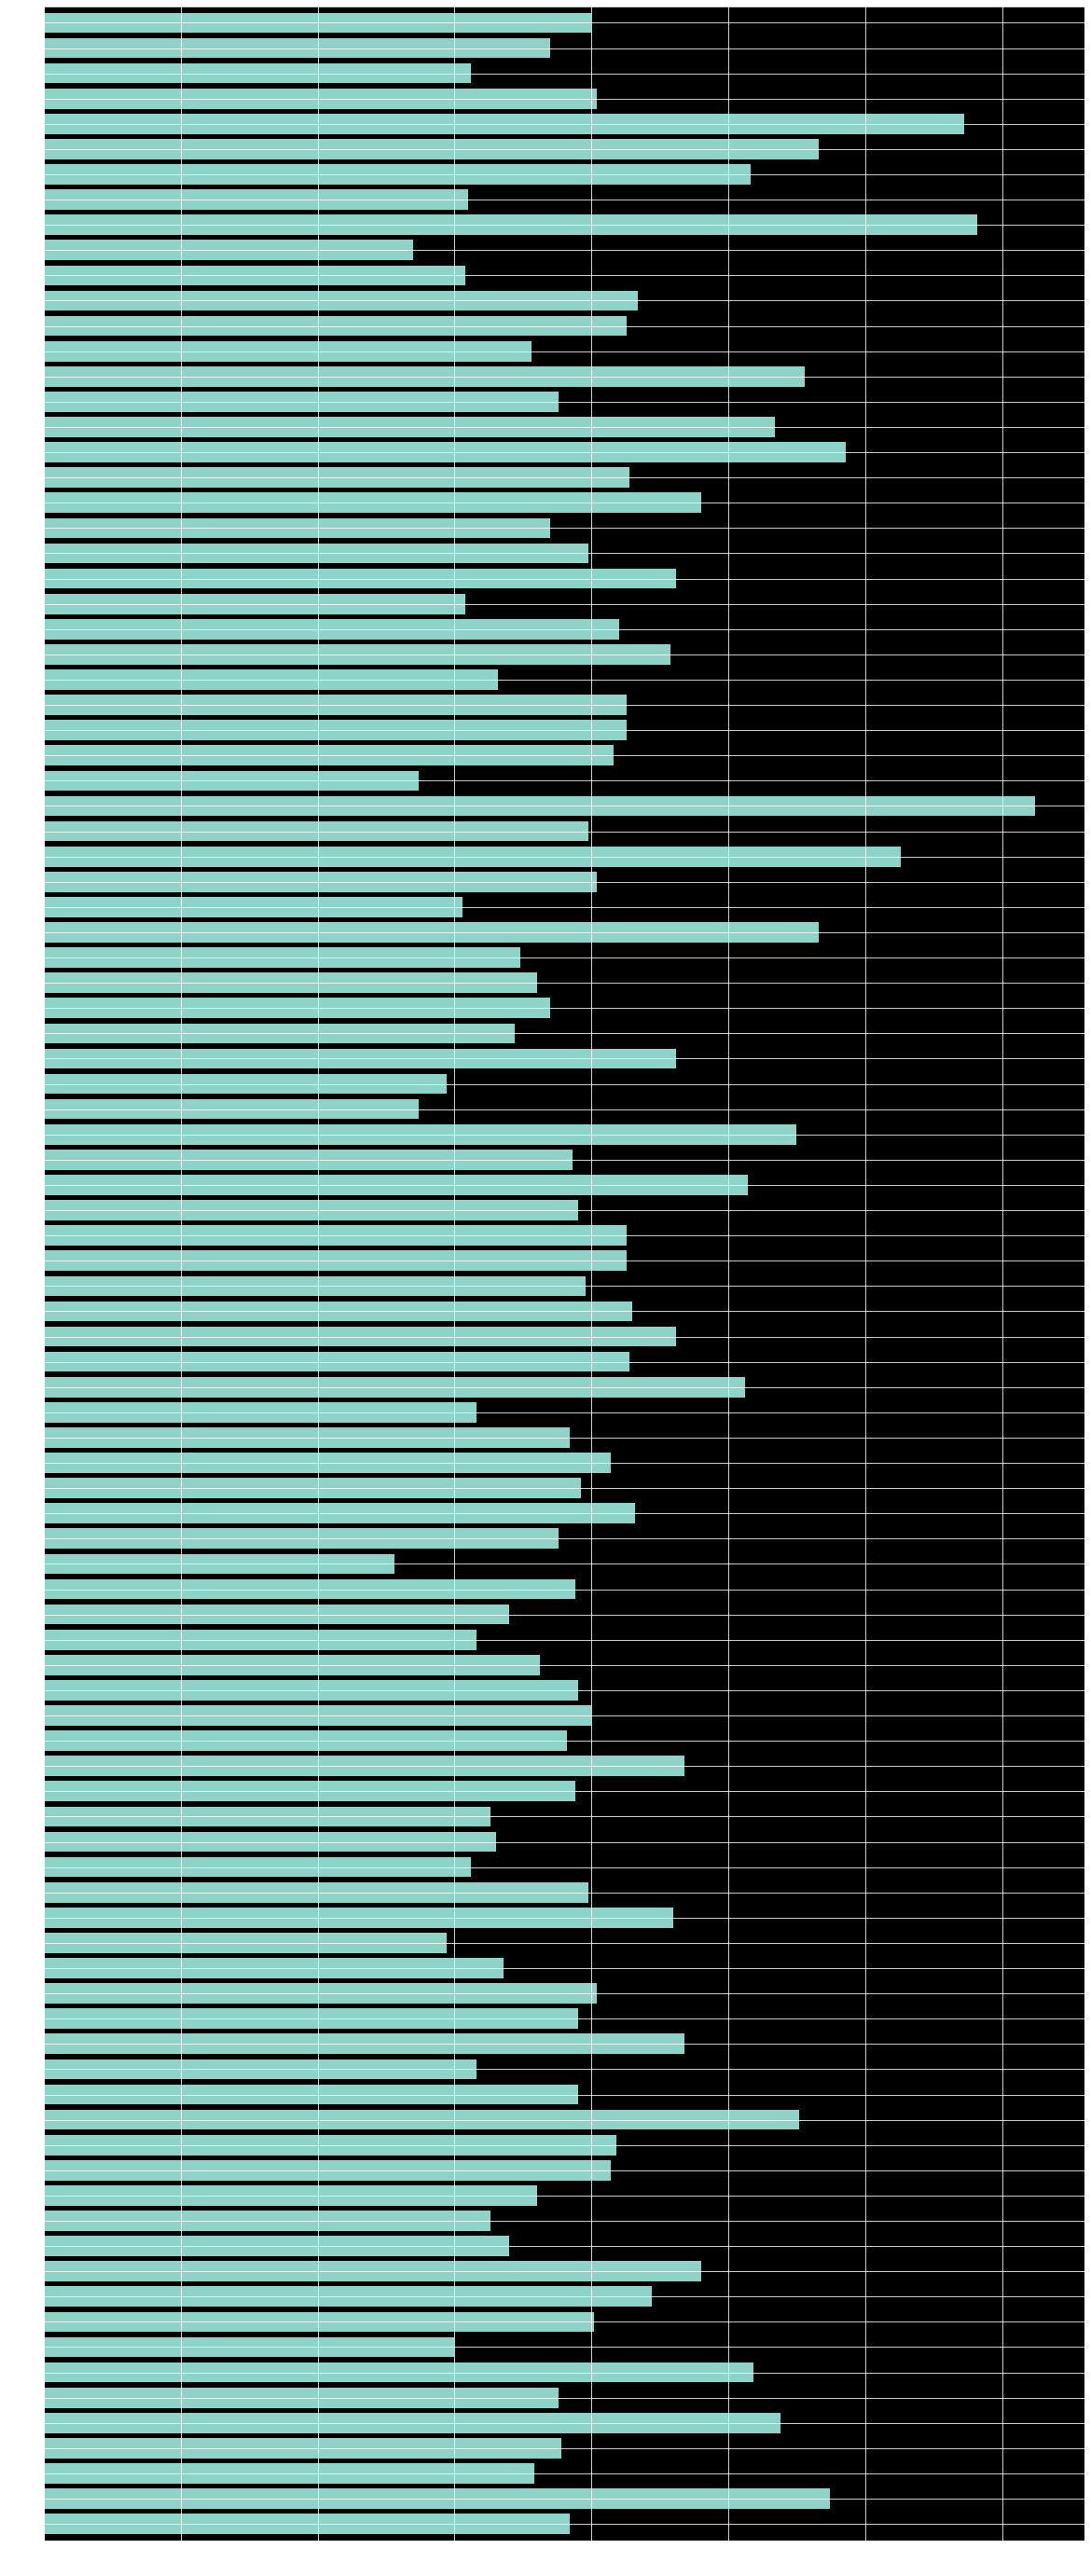

In [7]:
plt.figure(figsize=(20,50))
plt.style.use('dark_background')
train.groupby('id')['cycle'].max().plot(kind='barh', width=.8, stacked=True, align='center')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine ID')
plt.grid(True)
plt.show()

## Processing Data

A testing dataset is provided where the engines are not ran until failure, and a complimentary vector is provided for the remaining useful life (RUL) for each engine ID. In order to match the engines in the test set with their corresponding RUL, we must concatenate the two datasets.

Since the engines in the test set are ran until failure, you can calculate the remaining cycles until failure by subtracting the current cycle from the maximum cycle for each engine ID. He does this for the test set as well. Since the remaining useful life for all the test engines are given, as well as their current cycle, the maximum cycles for each engine can be calculated.

In [8]:
train['remaining_cycles'] = train.groupby(['id'])['cycle'].transform(max)-train['cycle']

In [9]:
train.head()

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,remaining_cycles
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
# Maximum cycles = cycles at test end + remaining useful life

maxCycles = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
maxCycles.columns = ['id', 'max_tested']
maxCycles['max_cycles'] = RUL['remaining_cycles'] + maxCycles['max_tested']
maxCycles.drop(['max_tested'], axis=1, inplace=True)

In [11]:
maxCycles.head()

,id,max_cycles
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [12]:
test = test.merge(maxCycles, on=['id'], how='left')

In [13]:
test['remaining_cycles'] = test['max_cycles'] - test['cycle']
test.drop(['max_cycles'], axis=1, inplace=True)

In [14]:
test.head()

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,remaining_cycles
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


He then uses 30 cycles until failure as the label for the dataset, where the label is set to 1 if there are 30 or less cycles remaining in the engine's life, and then 0 otherwise.

In [15]:
maintenanceCycle = 30

train['maintenance_reqd'] = train['remaining_cycles'].apply(lambda x: 1 if x <= maintenanceCycle else 0)
test['maintenance_reqd'] = test['remaining_cycles'].apply(lambda x: 1 if x <= maintenanceCycle else 0)

In [17]:
train

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,remaining_cycles,maintenance_reqd
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1


He then creates a plot for all sensors for each engine setting in order to find what can be removed from the data.

In [21]:
settings = col_names[2:5]
sensors = col_names[5:-2]

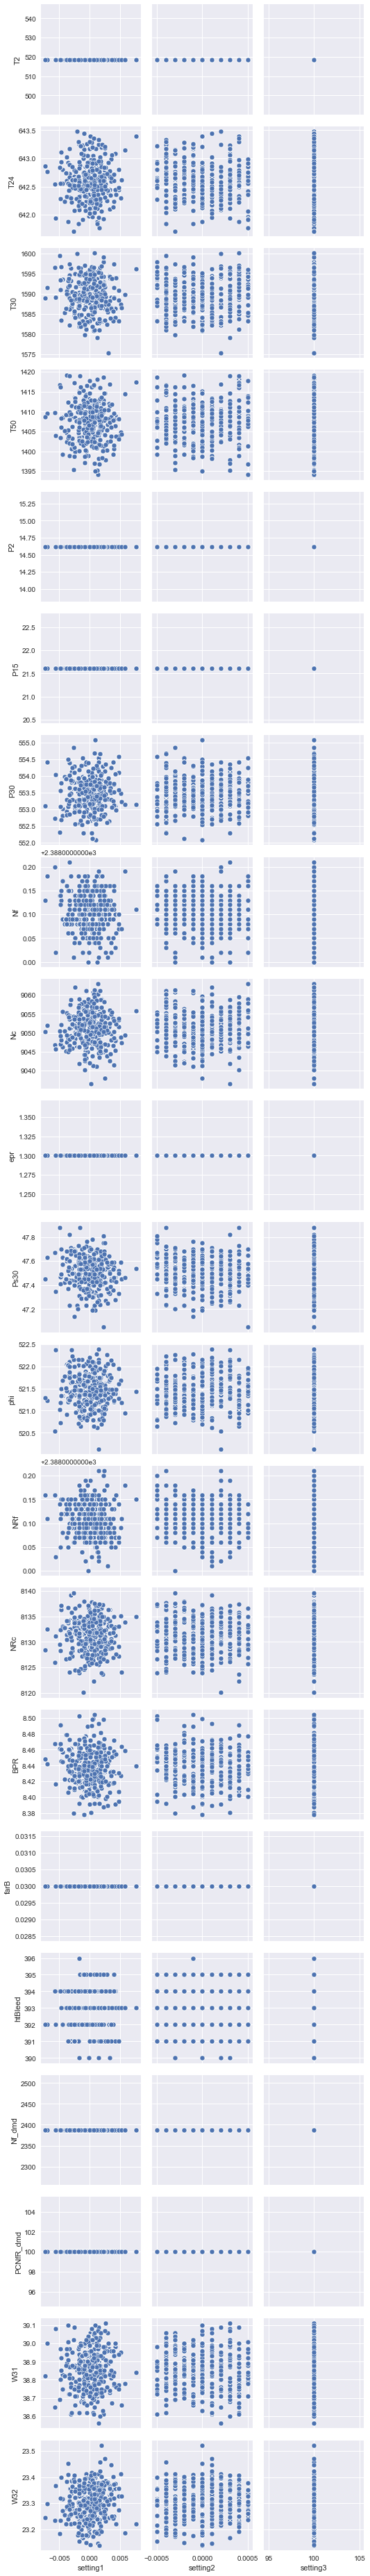

In [32]:
plt.style.use('seaborn')
sns.pairplot(test.query('cycle'), x_vars=settings, y_vars=sensors, palette='muted')

Removing sensors and operational settings that don't add value

In [34]:
testAbridged = test.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd'], axis=1)

In [35]:
X = train.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles', 'maintenance_reqd'], axis=1)

In [36]:
y = train.maintenance_reqd

## Creating Models

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=8)

In [39]:
lgbClass = lgbm.LGBMClassifier(learning_rate=.01, n_estimators=5000, num_leaves=100,
                               objective='binary', metrics='auc', random_state=50, n_jobs=-1)

In [58]:
lgbClass.fit(X_train, y_train)
lgbClass.score(X_test, y_test)
lgbPred = lgbClass.predict(X_test)

print('Acc Score: ',accuracy_score(y_test, lgbPred))
print('Roc Auc Score: ',roc_auc_score(y_test, lgbPred))
print('Precision Score: ',precision_score(y_test, lgbPred))
print('Recall Score: ',recall_score(y_test, lgbPred))
print('f1 score: ',f1_score(y_test, lgbPred))

Acc Score:  0.9578386236976012
Roc Auc Score:  0.8970971780769162
Precision Score:  0.902135231316726
Recall Score:  0.8099041533546326
f1 score:  0.8535353535353536


In [43]:
stKF = StratifiedKFold(n_splits=5)
xgbClass = xgb.XGBClassifier(n_estimators=725, n_jobs=-1)

In [44]:
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}

In [45]:
rscvClass = RandomizedSearchCV(xgbClass, param_distributions=params, cv=stKF, n_jobs=-1)

In [46]:
rscvClass.fit(X_train, y_train)
rscvPred = rscvClass.predict(X_test)

C:\Users\Arash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
print("Best Parameter: \n", rscvClass.best_params_)
print("XGBClassifier Acc Score: ", accuracy_score(rscvPred,y_test))

Best Parameter: 
 {'subsample': 0.8, 'scale_pos_weight': 50, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.060000000000000005, 'gamma': 0.5, 'colsample_bytree': 0.5000000000000001}
XGBClassifier Acc Score:  0.9508117276472013


In [49]:
testPred = lgbClass.predict(testAbridged.drop(['remaining_cycles', 'maintenance_reqd'], axis=1))

In [54]:
cm = confusion_matrix(testAbridged.iloc[:,-1], testPred, labels=None, sample_weight=None)

In [56]:
print("Test Accuracy Score: ", accuracy_score(testAbridged.iloc[:,-1], testPred))

Test Accuracy Score:  0.986484422724496


<AxesSubplot:>

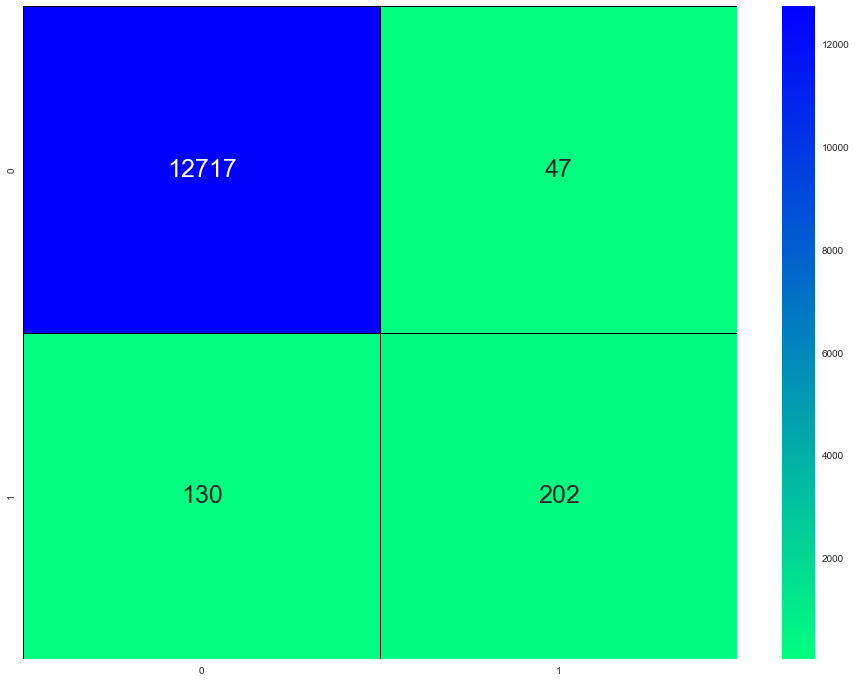

In [57]:
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, annot_kws={"size": 25}, linewidths=0.7, linecolor="black", cmap="winter_r", fmt="d")

## Summary

The study recreated here uses classification through boosted trees in order to determine when an engine needs maintenance. The point where maintenance required was arbitrarily chosen to be when an engine has 30 cycles until failure, and the model seems to predict when the engine meets this 30 cycle point based on the readings of the various sensors required. There was some discussion in the comments of this Kaggle submission about the validity of this method, and whether it provides artificially high accuracy from the model, but it is apparently a valid method used in industry for these types of problems. Based on this work, and reviewing other works, the ideal approach to this problem seems to be classification rather than linear or logistic regression.